In [ ]:
#| hide
#|eval: false
# This is to render Plotly plots into HTML
# For more information, see https://quarto.org/docs/interactive/widgets/jupyter.html#plotly
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"

import warnings
warnings.simplefilter('ignore')

import logging
logging.getLogger('statsforecast').setLevel(logging.ERROR)

# Statistical Models

> Statistical Models

- skip_showdoc: true
- skip_exec: true

In [ ]:
#| default_exp stats

## Data Extraction

In [ ]:
import numpy as np
import pandas as pd
from pmdarima import auto_arima
import matplotlib.pyplot as plt

# Generate a sine wave for demonstration

In [ ]:
cycles = 26
weeks = cycles * 2
resolution = 7


np.random.seed(0)
t = np.linspace(0, cycles * np.pi, weeks * resolution)

waveform = np.random.normal(scale=0.5, size=len(t)) + 0.5 * np.sign(np.sin(0.67 * t))
sine_wave = np.sin(t) + 0.3*np.sin(4.71*t) + waveform

[<matplotlib.lines.Line2D>]

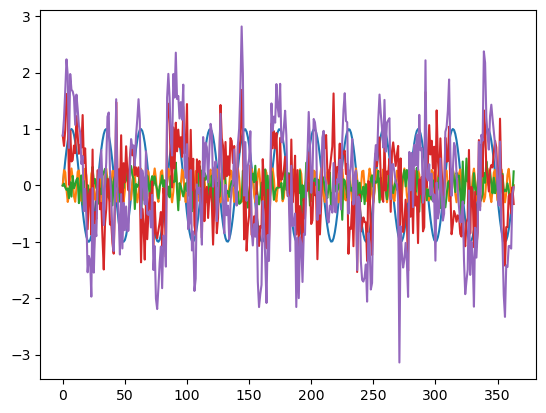

In [ ]:
plt.plot( np.sin(t))
plt.plot(0.3*np.sin(5*t))
plt.plot(np.random.normal(scale=0.2, size=len(t)))
plt.plot(waveform)
plt.plot(sine_wave)

In [ ]:
# Create a Pandas DataFrame
df = pd.DataFrame({'y': sine_wave})
df['unique_id'] = 1

In [ ]:
rng = pd.date_range('04/01/2021', periods=df.shape[0], freq='D')
df['ds'] = rng
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   y          364 non-null    float64       
 1   unique_id  364 non-null    int64         
 2   ds         364 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 8.7 KB


In [ ]:
import altair as alt

def long_form(df_plot):
    return df_plot.melt('ds', var_name='unique_id', value_name='price')

def altair_plot(df_plot): 
    highlight = alt.selection_point(on='mouseover', fields=['unique_id'], nearest=True)

    base = alt.Chart(df_plot).encode(
        x='ds:T',
        y='price:Q',
        color='unique_id:N'
    )

    points = base.mark_circle().encode(
        opacity=alt.value(0)
    ).add_params(
        highlight
    ).properties(
        width=1000
    )

    lines = base.mark_line().encode(
        size=alt.condition(~highlight, alt.value(1), alt.value(3))
    )

    return points + lines

In [ ]:
from tqdm.autonotebook import tqdm
from statsforecast import StatsForecast
from statsforecast.models import (
    AutoARIMA,
    HoltWinters,
    CrostonClassic as Croston, 
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive,
    SeasonalExponentialSmoothing,
)

from statsforecast.utils import AirPassengersDF, ConformalIntervals
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

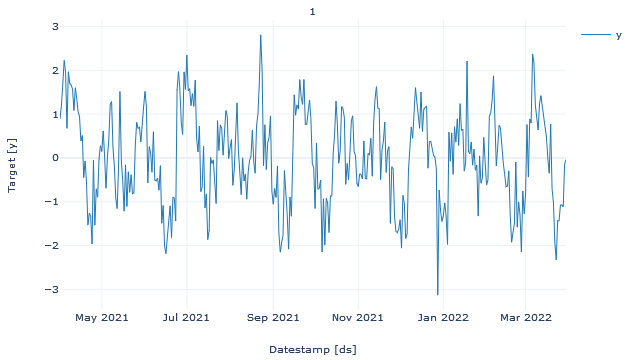

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = (15,4)
StatsForecast.plot(df, engine='plotly')

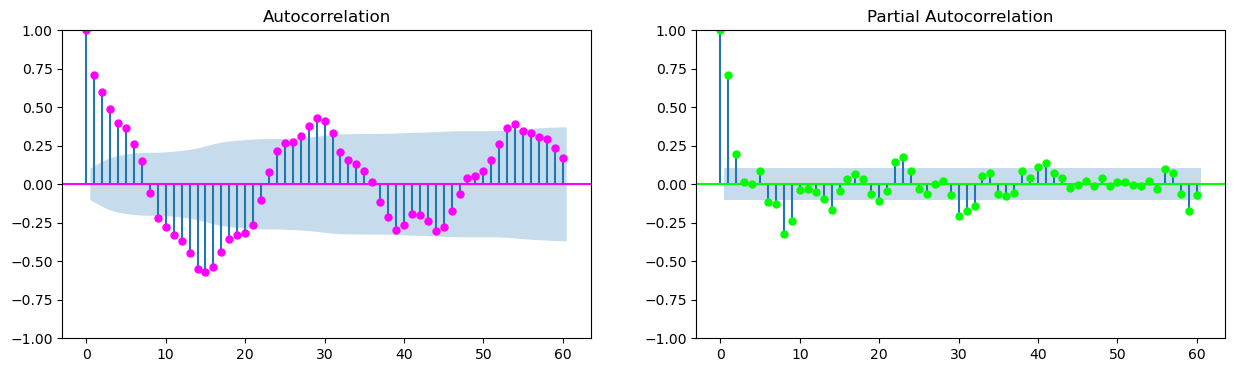

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2)

plot_acf(df["y"],  lags=60, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation");

plot_pacf(df["y"],  lags=60, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation')

plt.show();

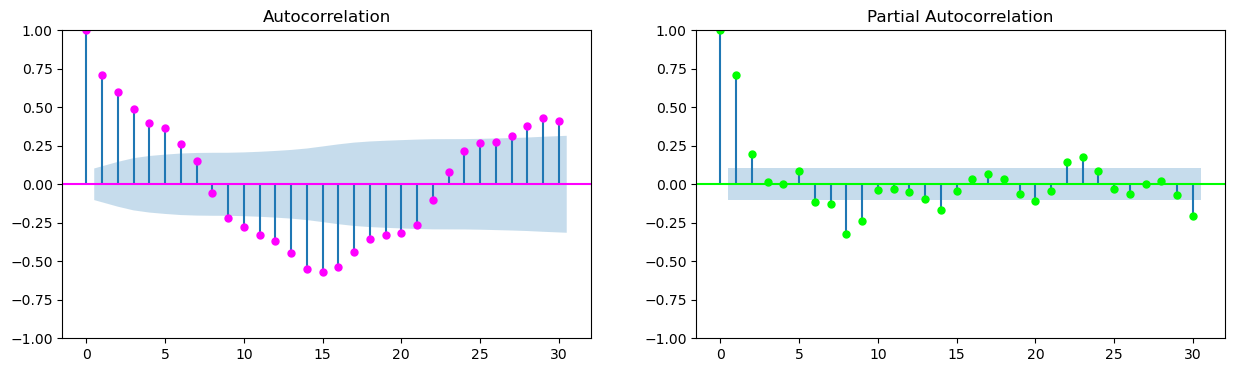

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2)

plot_acf(df["y"],  lags=30, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation");

plot_pacf(df["y"],  lags=30, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation')

plt.show();

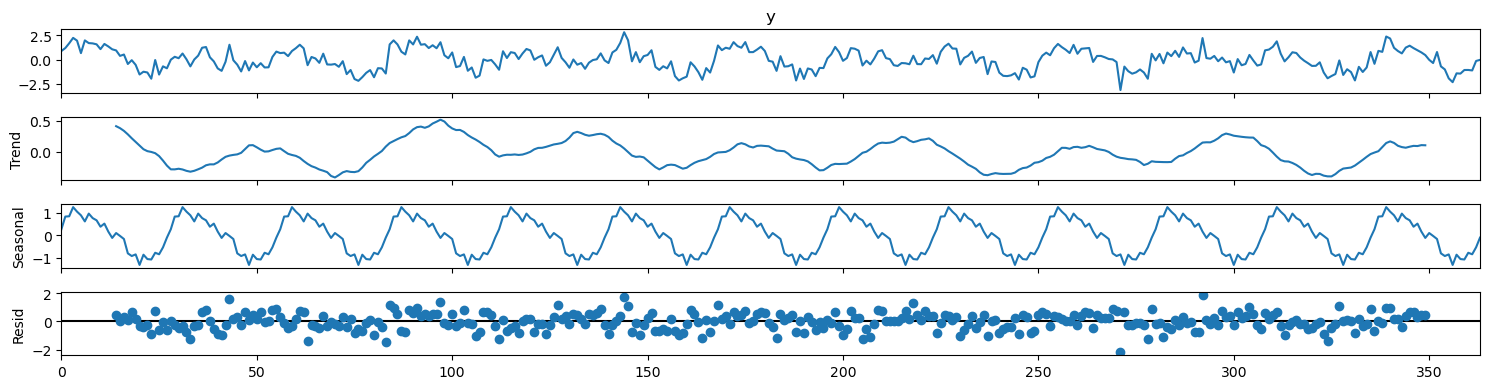

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose 
a = seasonal_decompose(df["y"], model = "additive", period=28)
a.plot();


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def plotSeasonalDecompose(
    x,
    model='additive',
    filt=None,
    period=None,
    two_sided=True,
    extrapolate_trend=0,
    title="Seasonal Decomposition"):

    result = seasonal_decompose(
            x, model=model, filt=filt, period=period,
            two_sided=two_sided, extrapolate_trend=extrapolate_trend)
    fig = make_subplots(
            rows=4, cols=1,
            subplot_titles=["Observed", "Trend", "Seasonal", "Residuals"])
    for idx, col in enumerate(['observed', 'trend', 'seasonal', 'resid']):
        fig.add_trace(
            go.Scatter(x=result.observed.index, y=getattr(result, col), mode='lines'),
                row=idx+1, col=1,
            )
    return fig


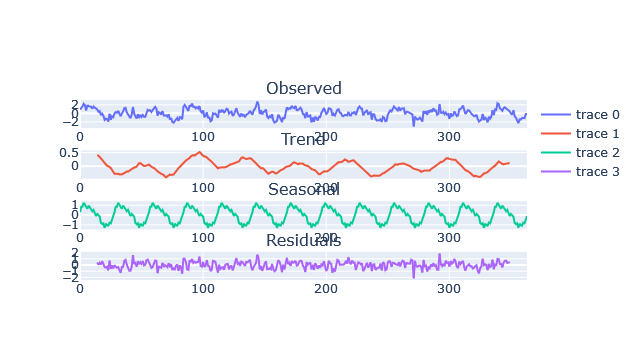

In [ ]:
plotSeasonalDecompose(
    df["y"],
    model="additive",
    period=28,
    title="Seasonal Decomposition")

## Create Model

In [ ]:
from statsforecast import models
models.__all__

['AutoARIMA',
 'AutoETS',
 'ETS',
 'AutoCES',
 'AutoTheta',
 'ARIMA',
 'AutoRegressive',
 'SimpleExponentialSmoothing',
 'SimpleExponentialSmoothingOptimized',
 'SeasonalExponentialSmoothing',
 'SeasonalExponentialSmoothingOptimized',
 'Holt',
 'HoltWinters',
 'HistoricAverage',
 'Naive',
 'RandomWalkWithDrift',
 'SeasonalNaive',
 'WindowAverage',
 'SeasonalWindowAverage',
 'ADIDA',
 'CrostonClassic',
 'CrostonOptimized',
 'CrostonSBA',
 'IMAPA',
 'TSB',
 'MSTL',
 'Theta',
 'OptimizedTheta',
 'DynamicTheta',
 'DynamicOptimizedTheta',
 'GARCH',
 'ARCH',
 'ConstantModel',
 'ZeroModel',
 'NaNModel']

In [ ]:
horizon = 28 * 2

train_size = weeks * resolution - horizon
train, test = df[:train_size], df[train_size:]


df.shape, train.shape, test.shape

((364, 3), (308, 3), (56, 3))

In [ ]:
len(test)

NameError: name 'futr_df' is not defined

In [ ]:
intervals = ConformalIntervals(h=horizon, n_windows=2)
season_length = 28

models = [
    AutoARIMA(season_length=season_length, prediction_intervals=intervals),
    HoltWinters(season_length=season_length, error_type="A"),
    #Croston(),
    SeasonalNaive(season_length=season_length),
    #HistoricAverage(),
    DOT(season_length=season_length),
    SeasonalExponentialSmoothing(alpha=0.8, season_length=season_length),
]

In [ ]:
sf = StatsForecast(
    df = train,
    models = models,
    freq = 'D',
    n_jobs=-1,
    verbose = True
)

## Forecast

In [ ]:
fore = sf.forecast(h=horizon,
                   #prediction_intervals=intervals,
                   
                 # level=[90]
                 )

Forecast:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
fore_plot = long_form(fore)
fore_plot

,ds,unique_id,price
0,2022-02-03,unique_id,1.000000
1,2022-02-04,unique_id,1.000000
2,2022-02-05,unique_id,1.000000
3,2022-02-06,unique_id,1.000000
4,2022-02-07,unique_id,1.000000
...,...,...,...
331,2022-03-26,SeasonalES,-0.611406
332,2022-03-27,SeasonalES,0.154510
333,2022-03-28,SeasonalES,-0.348743
334,2022-03-29,SeasonalES,-0.824028


In [ ]:
y_plot = df[int(-horizon*2):]
y_plot.columns

Index(['y', 'unique_id', 'ds'], dtype='object')

In [ ]:
y_plot.rename(columns={'y': 'price'}, inplace= True)

In [ ]:
fore_plot = pd.concat([fore_plot,y_plot])
fore_plot

,ds,unique_id,price
0,2022-02-03,unique_id,1.000000
1,2022-02-04,unique_id,1.000000
2,2022-02-05,unique_id,1.000000
3,2022-02-06,unique_id,1.000000
4,2022-02-07,unique_id,1.000000
...,...,...,...
359,2022-03-26,1,-1.075326
360,2022-03-27,1,-1.071706
361,2022-03-28,1,-1.120472
362,2022-03-29,1,-0.144448


In [ ]:
altair_plot(fore_plot)

alt.LayerChart(...)

In [ ]:
fore.iloc[:,2:].head()

,AutoARIMA,HoltWinters,SeasonalNaive,DynamicOptimizedTheta,SeasonalES
0,0.229876,0.258348,-0.085467,0.578754,0.034635
1,0.685502,0.835712,0.576483,1.112219,0.562846
2,0.532418,0.842493,-0.385228,1.109493,-0.068535
3,1.296907,1.168408,0.719438,1.385704,0.892200
4,0.933898,1.007089,0.352424,1.289210,0.525480


## Cross-Validation

In [ ]:
n_windows = 5
crossvalidation_df = sf.cross_validation(
    h = horizon,
    step_size = horizon,
    n_windows = n_windows
  )

Cross Validation Time Series 1:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
crossvalidation_df.head()

,ds,cutoff,y,AutoARIMA,HoltWinters,SeasonalNaive,DynamicOptimizedTheta,SeasonalES
unique_id,,,,,,,,
1,2021-04-29,2021-04-28,-0.011988,-0.803447,-1.114567,0.882026,-0.910163,0.882026
1,2021-04-30,2021-04-28,0.285825,-0.849951,-1.202070,1.184884,-0.910163,1.184884
1,2021-05-01,2021-04-28,0.139007,-0.827595,-1.289573,1.680301,-0.910163,1.680301
1,2021-05-02,2021-04-28,0.624833,-0.838343,-1.377077,2.234016,-0.910163,2.234016
1,2021-05-03,2021-04-28,0.029964,-0.833176,-1.464580,1.950096,-0.910163,1.950096


In [ ]:
crossvalidation_df.drop('cutoff', axis=1, inplace=True)

In [ ]:
crossvalidation_df_plot = long_form(crossvalidation_df)

In [ ]:
altair_plot(crossvalidation_df_plot)

alt.LayerChart(...)

## Performance

In [ ]:
from datasetsforecast.losses import (mae, mape, mase, rmse, smape)

In [ ]:
fore.info(), fore.columns, fore['AutoARIMA'].values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   unique_id              56 non-null     int64         
 1   ds                     56 non-null     datetime64[ns]
 2   AutoARIMA              56 non-null     float32       
 3   HoltWinters            56 non-null     float32       
 4   SeasonalNaive          56 non-null     float32       
 5   DynamicOptimizedTheta  56 non-null     float32       
 6   SeasonalES             56 non-null     float32       
dtypes: datetime64[ns](1), float32(5), int64(1)
memory usage: 2.1 KB


(None,
 Index(['unique_id', 'ds', 'AutoARIMA', 'HoltWinters', 'SeasonalNaive',
        'DynamicOptimizedTheta', 'SeasonalES'],
       dtype='object'),
 array([ 0.22987553,  0.6855018 ,  0.5324179 ,  1.296907  ,  0.93389785,
         1.0671949 ,  0.5716412 ,  1.4716152 ,  0.6917453 ,  0.95640403,
         0.4769931 ,  0.58612704,  1.0626335 ,  0.30788222,  0.2735823 ,
         0.34365815, -0.02484687,  0.14583941, -0.24158752, -1.596629  ,
        -1.0124251 , -0.54332614, -0.99400973, -0.8594592 , -0.24258256,
        -0.69162637, -1.2751557 ,  0.04646311,  0.08479773,  0.6407017 ,
         0.08987495,  1.0205237 ,  0.6548361 ,  0.9910863 ,  0.4315685 ,
         1.3673506 ,  0.661564  ,  0.8148673 ,  0.09596778,  0.24554151,
         1.631837  ,  0.2345393 ,  0.18494536,  0.36019734, -0.09524097,
         0.1778594 , -0.26101044, -0.8905563 , -1.1690307 , -0.25150737,
        -0.7923761 , -0.65975606,  0.11130547, -0.3994452 , -0.95437896,
        -0.22174656], dtype=float32))

In [ ]:
rmse_score = rmse(test['y'].values, fore['HoltWinters'].values)
print("RMSE between forecast and real: ", rmse_score)

RMSE between forecast and real:  0.6662927609114181


In [ ]:
def evaluate_performace(y_hist, y_true, y_pred):
    #y_true = y_true.merge(y_pred, how='left', on=['unique_id', 'ds'])
    evaluation = {}
    print(y_pred.columns)
    for i, model in enumerate(y_pred.columns):
        if i < 2: continue
        evaluation[model] = {}
        for metric in [mase, mae, mape, rmse, smape]:
            metric_name = metric.__name__
            if metric_name == 'mase':
                evaluation[model][metric_name] = metric(y_true['y'].values, 
                                                    y_pred[model].values, 
                                                    y_hist['y'].values, seasonality=12)
            else:
                evaluation[model][metric_name] = metric(y_true['y'].values, y_pred[model].values)
    return pd.DataFrame(evaluation)


In [ ]:
evaluate_performace(train, test, fore).style.background_gradient(cmap ='YlGn', axis = 1,low=0.5, high=0.6)

Index(['unique_id', 'ds', 'AutoARIMA', 'HoltWinters', 'SeasonalNaive',
       'DynamicOptimizedTheta', 'SeasonalES'],
      dtype='object')


,AutoARIMA,HoltWinters,SeasonalNaive,DynamicOptimizedTheta,SeasonalES
mase,0.552126,0.376421,0.631609,0.442360,0.564715
mae,0.791465,0.539595,0.905403,0.634117,0.809510
mape,165.287808,113.312947,141.615219,147.870999,135.201094
rmse,0.904719,0.666293,1.083679,0.769611,0.951087
smape,116.076059,86.779071,130.180295,89.625308,123.576836


In [ ]:
results = evaluate_performace(train, test, fore)
results.to_csv('Data/Stat_results2.csv')

Index(['unique_id', 'ds', 'AutoARIMA', 'HoltWinters', 'SeasonalNaive',
       'DynamicOptimizedTheta', 'SeasonalES'],
      dtype='object')


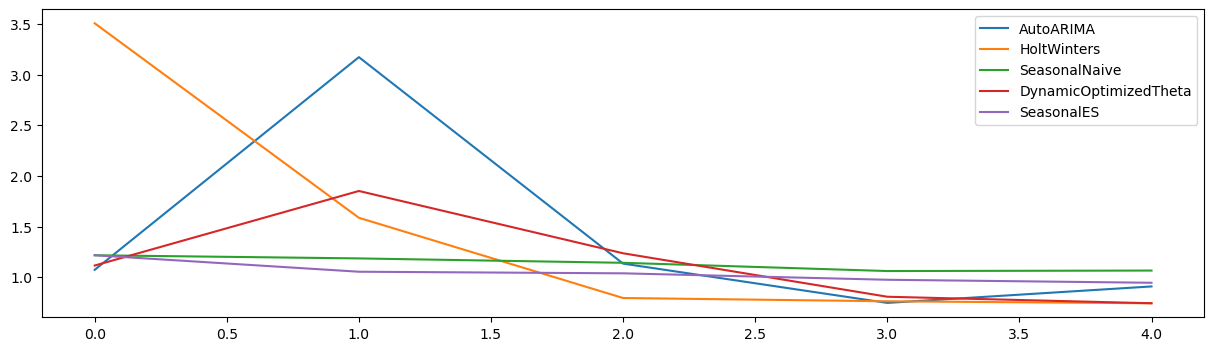

In [ ]:
cutoff = crossvalidation_df['cutoff'].unique()
n_models = len(crossvalidation_df.columns) - 3
rmse_score = np.zeros((n_windows,n_models), dtype=np.float32)

for i, model in enumerate(crossvalidation_df.columns):
    if i < 3:
        continue    
    for k in range(len(cutoff)): 
        cv = crossvalidation_df[crossvalidation_df['cutoff'] == cutoff[k]]
    
        rmse_score[k,i-3] = rmse(cv[f'{model}'], cv.y)
    plt.plot(rmse_score[:,i-3], label = f'{model}')
        

plt.legend()
plt.show()


In [ ]:
rmse_score

array([[1.0727004 , 3.50553   , 1.2164838 , 1.1151466 , 1.2164838 ],
       [3.1713963 , 1.5862346 , 1.1854093 , 1.8507779 , 1.05398   ],
       [1.1339344 , 0.7946055 , 1.142026  , 1.2360449 , 1.0382159 ],
       [0.7463759 , 0.76247925, 1.0607373 , 0.8071447 , 0.97478694],
       [0.908804  , 0.74267846, 1.0655735 , 0.7429336 , 0.94502705]],
      dtype=float32)